In [4]:
BUCKET='hohukelkazan'

# Prepare

以下の流れはベイズ分類の時と変わらない

1. トレーニング日に関するデータのcsvの読み込み(スキーマ: header)
2. 読み込んだトレーニング日に関するデータをSpark SQLビューに変換
3. 飛行データのスキーマ定義
4. 飛行データのcsvの読み込み(スキーマ: 3で読み込んだやつ)
5. 読み込んだ飛行データをSpark SQLビューに変換
6. 2,5の結果をjoinさせてトレーニングデータ作成


In [5]:
# read
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))

In [6]:
# Spark SQLビューに変換
traindays.createOrReplaceTempView('traindays')

In [7]:
# スキーマ定義(TAXI_OUTも数値型にする)
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
  if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'TAXI_OUT']:
    return StructField(colname, FloatType(), True)
  else:
    return StructField(colname, StringType(), True)
  
schema = StructType([get_structfield(colname) for colname in header.split(',')])
print(schema)

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,FloatType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true),

In [8]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET) # 1/30th
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)
flights_csv = spark.read\
            .schema(schema)\
            .csv(inputs)
# tmpビュー作成
flights_csv.createOrReplaceTempView('flights')

In [9]:
# create train data
traindayquery = """
select
  f.*
from flights f
join traindays t
on f.FL_DATE == t.FL_DATE
where
  t.is_train_day == 'True'
"""
traindata = spark.sql(traindayquery)

In [10]:
# describe()メソッドは列ごとの統計情報を計算して、show()はその結果を表示するよ
# NULLはカウントしないからcountに差がでるよ(ex. スケジュールされたけど出発しなかった場合など)
traindata.describe().show()

+-------+----------+--------------+------------------+-------+------------------+------------------+---------------------+---------------------+------+------------------+-------------------+-------------------+-----+-------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-----------------+--------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+--------------------+-----+-----------+
|summary|   FL_DATE|UNIQUE_CARRIER|        AIRLINE_ID|CARRIER|            FL_NUM| ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET_ID|ORIGIN|   DEST_AIRPORT_ID|DEST_AIRPORT_SEQ_ID|DEST_CITY_MARKET_ID| DEST|       CRS_DEP_TIME|           DEP_TIME|         DEP_DELAY|          TAXI_OUT|         WHEELS_OFF|          WHEELS_ON|           TAXI_IN|       CRS_ARR_TIME

 -> すべてのcount数が同じになった  
 ただ根本解決にはなってない
 -> キャンセル、迂回が発生したかを表す絡むを見てレコードを絞った方が確実

In [11]:
query = """
select
  cancelled, diverted
from flights
limit 10
"""
spark.sql(query).show()

query = """
select
  cancelled, diverted
from flights
where
  cancelled != '0.00'
limit 10
"""
spark.sql(query).show()

query = """
select
  cancelled, diverted
from flights
where
  diverted != '0.00'
limit 10
"""
spark.sql(query).show()

+---------+--------+
|cancelled|diverted|
+---------+--------+
|     0.00|    0.00|
|     0.00|    0.00|
|     0.00|    0.00|
|     0.00|    0.00|
|     0.00|    0.00|
|     0.00|    0.00|
|     0.00|    0.00|
|     0.00|    0.00|
|     0.00|    0.00|
|     0.00|    0.00|
+---------+--------+

+---------+--------+
|cancelled|diverted|
+---------+--------+
|     1.00|    0.00|
|     1.00|    0.00|
|     1.00|    0.00|
|     1.00|    0.00|
|     1.00|    0.00|
|     1.00|    0.00|
|     1.00|    0.00|
|     1.00|    0.00|
|     1.00|    0.00|
|     1.00|    0.00|
+---------+--------+

+---------+--------+
|cancelled|diverted|
+---------+--------+
|     0.00|    1.00|
|     0.00|    1.00|
|     0.00|    1.00|
|     0.00|    1.00|
|     0.00|    1.00|
|     0.00|    1.00|
|     0.00|    1.00|
|     0.00|    1.00|
|     0.00|    1.00|
+---------+--------+



どうやらキャンセルされたか、迂回されたかは0,1で格納されているみたい

In [12]:
# もっとしっかり取り除こう
traindayquery = """
select
  f.*
from flights f
join traindays t
on f.FL_DATE == t.FL_DATE
where
  t.is_train_day == 'True' and
  f.cancelled == '0.00' and
  f.diverted == '0.00'
"""
traindata = spark.sql(traindayquery)
traindata.describe().show()

+-------+----------+--------------+------------------+-------+------------------+------------------+---------------------+---------------------+------+------------------+-------------------+-------------------+-----+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+-------------------+-------------------+---------+-----------------+--------+------------------+------------------+------------------+--------------------+------------------+------------------+--------------------+-----+-----------+
|summary|   FL_DATE|UNIQUE_CARRIER|        AIRLINE_ID|CARRIER|            FL_NUM| ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET_ID|ORIGIN|   DEST_AIRPORT_ID|DEST_AIRPORT_SEQ_ID|DEST_CITY_MARKET_ID| DEST|       CRS_DEP_TIME|           DEP_TIME|         DEP_DELAY|          TAXI_OUT|         WHEELS_OFF|          WHEELS_ON|          TAXI_IN|       CRS_ARR_TIME|           ARR_TIME|   

NULLを除外した時と同じ結果が得られた

# トレーニング

トレーニングデータの各レコードは、LabeldedPointクラスに変換する必要がある
- https://spark.apache.org/docs/latest/api/java/org/apache/spark/ml/classification/LogisticRegressionModel.html

In [32]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [14]:
def to_example(fields):
  return LabeledPoint(\
           float(fields['ARR_DELAY'] < 15), # on-time? \
           [\
             fields['DEP_DELAY'], \
             fields['TAXI_OUT'], \
             fields['DISTANCE'], \
           ])

In [15]:
# トレーニング用のラベルと入力変数だけを取り出したデータ
examples = traindata.rdd.map(to_example)

### トレーニング実施

In [16]:
# intercept: 切片
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)
print(lrmodel.weights, lrmodel.intercept)

[-0.22138495484050652,-0.1950036261428732,0.0006005099885871358] 6.787218175020116


左から、出発遅延時間, タクシーアウト時間, フライト距離のウェイトと切片
- 出発遅延時間、タクシーアウト時間: 大きくなるほどon-timeの確率下がる -> ウェイトがマイナス
- フライト距離: 大きくなるほどon-timeの確率上がる -> ウェイトがプラス

### 予測

In [17]:
lrmodel.predict([6.0, 12.0, 594.0])

1

In [18]:
lrmodel.predict([36.0, 12.0, 594.0])

0

In [21]:
lrmodel.clearThreshold()
lrmodel.predict([6.0, 12.0, 594.0])

0.9699845491569308

In [22]:
lrmodel.predict([36.0, 12.0, 594.0])

0.0404661885071159

In [33]:
dist = np.arange(36.0, 12.0, 594.0)
#dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]

Text(0,0.5,'probability of ontime arrival')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


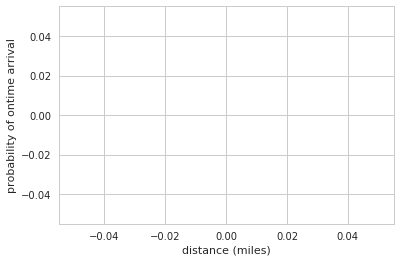

In [34]:
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance (miles)')
plt.ylabel('probability of ontime arrival')